In [2]:
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import torch
import spacy
import json
import numpy as np
import matplotlib.pyplot as plt

# Derive relation features
This script derives different kinds of features from the relations description.


## Description Embeddings

Load data and language model for embedding

In [3]:
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("entityLinker", last=True)
model = SentenceTransformer('all-MiniLM-L6-v2')

text_file = '../data/wikidata5m_inductive/wikidata5m_relation.txt'

relation_uri_2_id = json.load(open('../data/wikidata5m_inductive/relation_uri_to_id.json'))
id_2_relation_uri = {i: r for r, i in relation_uri_2_id.items()}

Derivation of description embeddings with the language model. The embeddings are stored according to the relation ids (relation_uri_to_id) in the matrix x.

In [4]:
x = torch.zeros((len(relation_uri_2_id.keys()), 384))
relation_not_required = []
id_2_description = {}
with open(text_file) as descriptions_file_in:
    for i, line in enumerate(tqdm(descriptions_file_in.readlines())):
        line = line[:-1]
        uri, description = line.split('\t', 1)
        doc = nlp(description)

        if uri not in relation_uri_2_id:
            relation_not_required.append(uri)
            continue

        id_2_description[relation_uri_2_id[uri]] = description

        for sent in doc.sents:
            embeddings = model.encode([sent.text])[0]
            x[relation_uri_2_id[uri]] = torch.tensor(embeddings)
            break
print('Relations not mentioned in the graph:', relation_not_required)

# some relations don't have a description, for those an empty string is added to avoid errors in the further processing
relations_without_descriptions = []
for i in range(len(relation_uri_2_id.keys())):
    if i not in id_2_description.keys():
        id_2_description[i] = ''
        relations_without_descriptions.append(id_2_relation_uri[i])

print('Relations without descriptions:', relations_without_descriptions)

100%|██████████| 825/825 [00:14<00:00, 57.80it/s]

Relations not mentioned in the graph: ['P1012', 'P301', 'P1423', 'P1151', 'P1204', 'P423']
Relations without descriptions: ['P2439', 'P1962', 'P3484']


In [43]:
torch.save(x, '../data/wikidata5m_inductive/relation_description_embedding.pt')

## Clustering of the relations with TSNE on the description embeddings to reduce the dimensionality for one-hot-encoding of the relation

In [5]:
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(x)

In [6]:
x_embedded.shape

(822, 2)

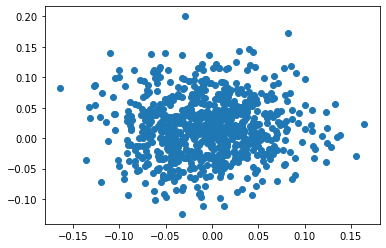

In [7]:
plt.scatter(x[:,0], x[:, 1])
plt.show()

We can not see a clear separation of clusters of descriptions. However, similar relations can still lie close to each other. To find this out, we apply clustering. We set the number of clusters to 50 as we want to reduce the number of demensions significantly and this seems appropriate with our whole architecture in mind.

In [8]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(x)

kmeans.labels_

Build a dictionary mapping from clusters to relations which is used to print the clusters with their belonging relations for manual check-up.

In [9]:
cluster_2_members = {i: [] for i in range(10)}
for id, cluster in enumerate(kmeans.labels_):
    cluster_2_members[cluster].append(id)

for cluster in cluster_2_members.keys():
    print('Cluster:', cluster)
    for id in cluster_2_members[cluster]:
        print(id_2_description[id])
    print('--- ---- ---')

Cluster: 0
applies to jurisdiction	of jurisdiction	linked to jurisdiction	belongs to jurisdiction	jurisdiction	country of jurisdiction	valid in jurisdiction	applies to territorial jurisdiction	applied to jurisdiction
index case of
topic's main template	topic's main infobox	infobox for this topic (main)	template for this topic (main)	main template
depends on software	dependency	software dependency	interfaces with	requires	runs on	software framework
category combines topics	combines topics	topics of category	subjects of category	cct	category intersects topics
significant event	key event	key incident	significant incident	notable event	notable incident	major event	big event	main events	fate	outcome	event	known for
history of topic	history	timeline of topic	chronology of topic
studies	learning what?	working on what?	is a study of	academic field for	scholarly field for	study of	research	researches
has part	formed from	formed out of	assembled from	assembled out of	created from	created out of	

The clusters look mostly reasonable. Of course not perfect, but enough for further experiments.

Create one hot encoding of clusters features matrix and write it to file.

In [10]:
clustered_features = torch.zeros((len(relation_uri_2_id.keys()), 10))
for cluster, members in cluster_2_members.items():
    for member in members:
        clustered_features[member, cluster] = 1
print(clustered_features.size())

torch.Size([822, 10])


In [12]:
torch.save(clustered_features, '../data/wikidata5m_inductive/relation_description_cluster_features_10.pt')